In [17]:
import math
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
import geojson

## Calculate 'dx' value: for a latitude, what is the distance between two 0.1 degree longitude

In [18]:
# Define latitude values
latitudes = np.linspace(-89.95, 89.95, 1800)  # Assuming a range of latitudes from -90 to 90 degrees

In [19]:
dist = 0.1*111*np.cos(np.deg2rad(latitudes))

In [20]:
# Define longitude values
longitude1 = 11.0  # First longitude
longitude2 = 11.1  # Second longitude

# Initialize an empty NumPy array for distances
distances = np.zeros_like(latitudes, dtype=float)

In [215]:
# Calculate distances using the Haversine formula
earth_radius = 6372  # Radius of the Earth in kilometers
for i, latitude in enumerate(latitudes):
    lat1 = np.radians(latitude)
    lon1 = np.radians(longitude1)
    lat2 = np.radians(latitude)
    lon2 = np.radians(longitude2)

    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = np.sin(dlat / 2) ** 2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon / 2) ** 2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))
    distance = earth_radius * c
    distances[i] = distance

# Create an xarray with latitude and distance
distance = xr.DataArray(distances, coords={'latitude': latitudes}, dims=['latitude'])
distance.attrs['units'] = 'kilometers'

## Southern Transect 
Mask starts from lat = 555 coz -34.5, so 555 = -34.45 \
Southern Transect therefore from lat = 554 = -34.55 \
-34.55 is in water with no E boundary. So -34.45 is taken to be southern transect : 34°45'00.0"S 54°45'00.0"W to 34°45'00.0"S 19°55'00.0"E (lon: 1255:1995)


In [21]:
lev = xr.open_dataset('/pscratch/sd/a/abhi305/depth_files/hr_depth.nc').refBottomDepth

In [22]:
# slice for memory usage

In [23]:
ds_merv = xr.open_dataset('/pscratch/sd/a/abhi305/Regrided_files_111_120_velocityMeridional/mer_v_highres_111_120_re.nc')
merv = ds_merv.timeMonthly_avg_velocityMeridional[0,...]

# topography is problem; set to nan
mervt = merv.where(merv != 0, np.nan)

In [24]:
v_south = mervt[:,555,1255:1996]

In [25]:
v_south_sum = np.nansum(v_south,axis=1)

In [26]:
v_south_sum.shape

(80,)

In [27]:
v_dx = v_south_sum*9000

### v_dx_dz

In [11]:
#########################################################################################################################
### now v_dx_dz (integrating bottom to top)
#########################################################################################################################

## empty psi south
psi_s = np.zeros_like(v_dx)

for i in range(78):
    psi_s[i] = (v_dx[i]+v_dx[i+1])/2 * (lev[i]-lev[i+1])
psi_s[79] = 0   

psi_sc = np.flip(np.cumsum(np.flip(psi_s)))

In [12]:
psi_sc

array([ 2681358.5  ,  2836663.8  ,  2970782.5  ,  3069215.2  ,
        3129989.   ,  3157517.5  ,  3156254.2  ,  3137142.   ,
        3121601.8  ,  3138597.   ,  3207739.8  ,  3325045.5  ,
        3465510.2  ,  3612663.   ,  3771309.2  ,  3944372.   ,
        4131480.2  ,  4339562.   ,  4574721.   ,  4838404.   ,
        5126892.   ,  5434916.   ,  5762036.5  ,  6114746.   ,
        6490893.   ,  6880313.5  ,  7277435.5  ,  7680161.5  ,
        8090254.   ,  8510705.   ,  8949596.   ,  9411937.   ,
        9899867.   , 10419783.   , 10972197.   , 11554802.   ,
       12160183.   , 12778340.   , 13399964.   , 14013181.   ,
       14606533.   , 15167386.   , 15681373.   , 16139857.   ,
       16538619.   , 16868176.   , 17106708.   , 17223978.   ,
       17192926.   , 16987564.   , 16588112.   , 15993321.   ,
       15207166.   , 14246779.   , 13138592.   , 11897290.   ,
       10543460.   ,  9100622.   ,  7607580.5  ,  6112173.5  ,
        4643849.   ,  3196618.8  ,  1745776.2  ,   2909

# Read data - vertVelocityTop

In [39]:
ds1 = xr.open_dataset('/pscratch/sd/a/abhi305/Regrided_files_111_120_vertVelocityTop/vertVelocityTop_111_120_re_time_avg.nc')
v = ds1.timeMonthly_avg_vertVelocityTop[0,...]

lat = ds1.lat
lon = ds1.lon

# topography is problem; set to nan
vt = v.where(v != 0, np.nan)

# Select Interior Region

In [40]:
with open('atlantic_mask.geojson') as f:
    fc = geojson.load(f) 

In [41]:
from mpas_tools.mesh.creation.signed_distance import mask_from_geojson

In [42]:
na_mask = mask_from_geojson(fc,lon,lat)

Mask from geojson
-----------------


In [43]:
vt = vt.values

In [44]:
vt[:,~na_mask] = np.nan

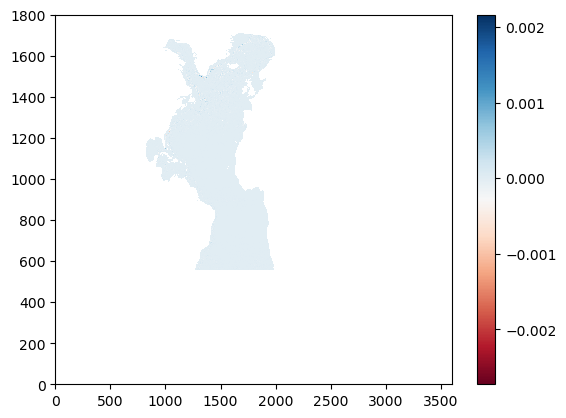

In [47]:
plt.pcolormesh(vt[0,...],cmap='RdBu')
plt.colorbar()

In [48]:
np.shape(vt)

(81, 1800, 3600)

# V_dA

In [49]:
v_sum = np.nansum(vt,axis=2)

In [50]:
## BUT ACTUALLY AN EMPTY SET (tmp) - sum of vertical vel along a latitude
v_da = np.zeros_like(v_sum)

In [51]:
dist_lat = 11076 #m

In [52]:
v_da.shape

(81, 1800)

In [53]:
for i in tqdm(range(len(dist))):
    v_da[:,i] = v_sum[:,i] * (dist[i] * 1000) * dist_lat

100%|██████████| 1800/1800 [00:00<00:00, 214578.99it/s]


# Adding bottom to top

## cumsum

In [54]:
## empty psi
psi = np.zeros_like(v_da)

for i in tqdm(range(len(lat))):
    for j in range(80):
        psi[j,i] = v_da[j,i]-v_da[j+1,i]

psi = psi[0:80, :]

psic = np.flip(np.nancumsum(np.flip(psi, axis=0), axis=0), axis=0) # taking cumsum in z axis

100%|██████████| 1800/1800 [00:00<00:00, 32180.67it/s]


### Taking cumsum in latitudes

In [55]:
psiclat = np.nancumsum(psic, axis=1)

## Add southern Transect

In [71]:
amoc_calc = np.zeros_like(psiclat)
for i in range(1800):
    amoc_calc[:,i] = psiclat[:,i]+psi_sc

# PLOT

/tmp/ipykernel_633681/3540569357.py:1: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('RdYlBu')


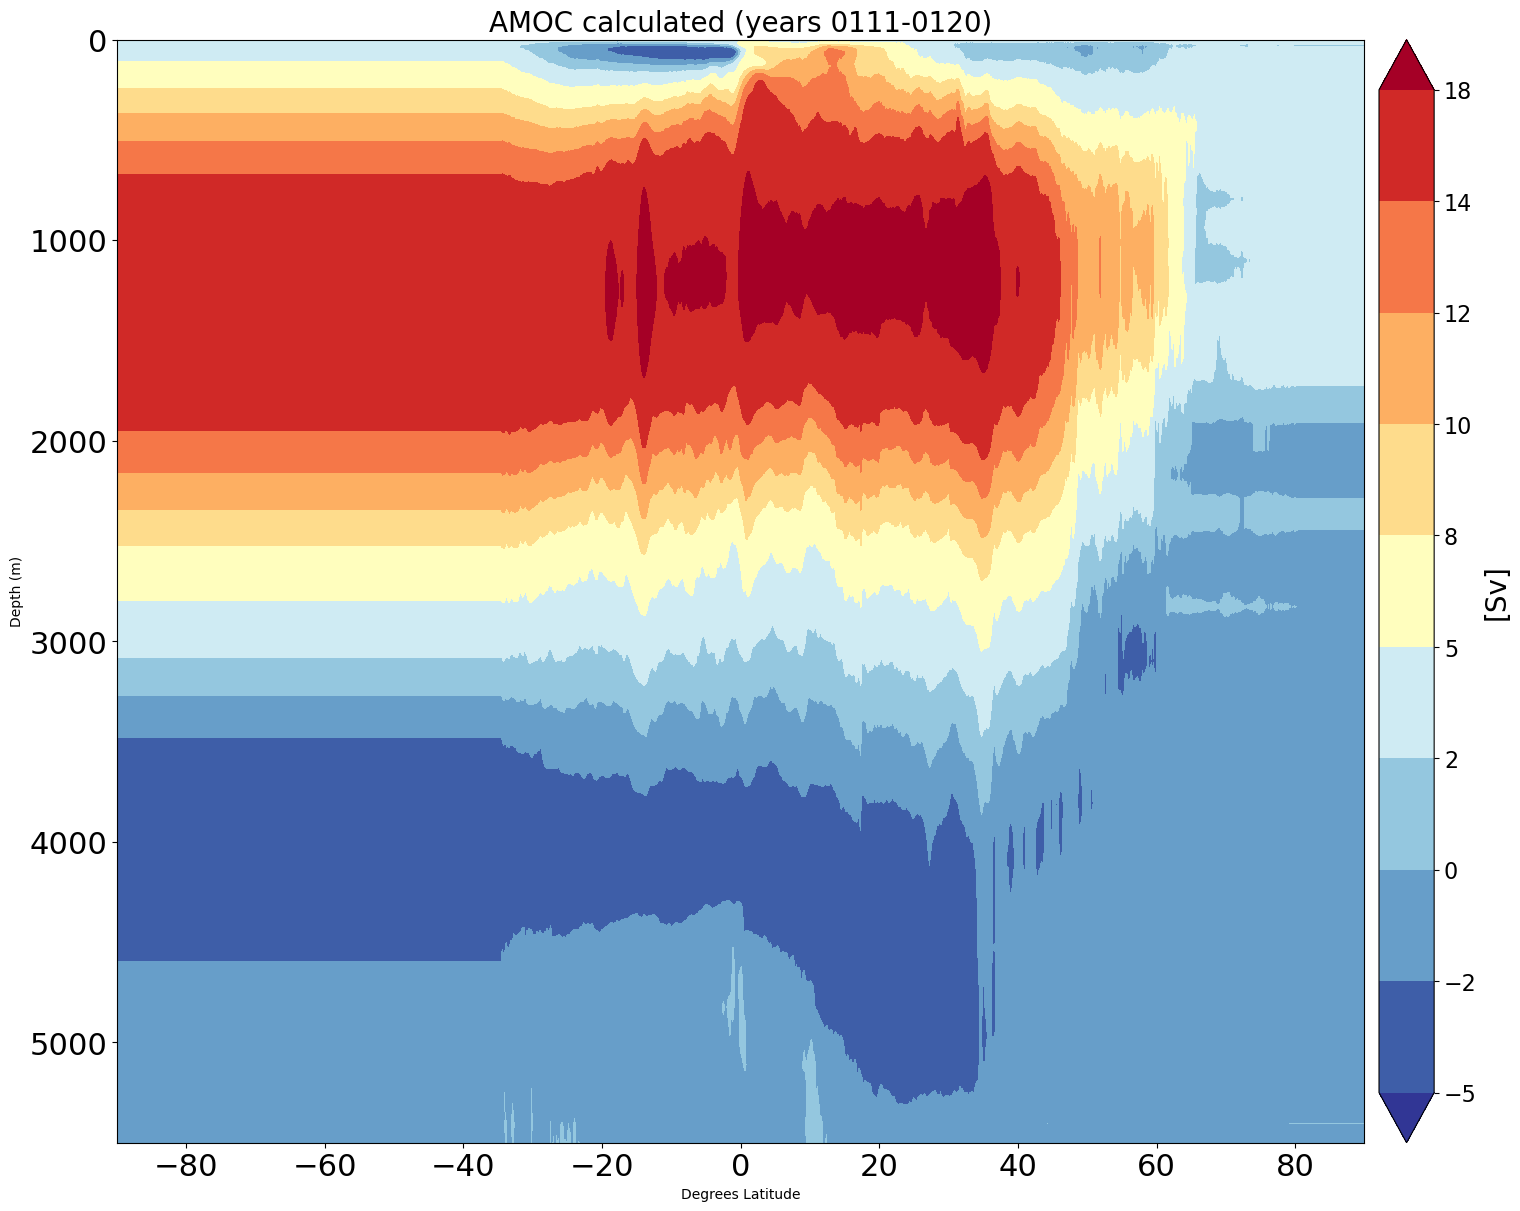

In [117]:
cmap = plt.cm.get_cmap('RdYlBu')
cmap_reversed = cmap.reversed()

fig, ax = plt.subplots(figsize=(16, 12))
cons=ax.contourf(lat.values, lev, amoc_calc*0.000001,                  
             levels=np.array([-5,-2,0,2,5,8,10,12,14,18]) ,
             #vmin = -2, vmax= 2,
             cmap=cmap_reversed,extend='both')
ax.set_ylim(5500,0)
plt.gca().set_facecolor("grey")  # nan values to grey
cbar = fig.colorbar(cons, orientation='vertical', pad=0.01)
cbar.set_label('[Sv]', size=20)
cbar.ax.tick_params(labelsize=16)
ax.set_ylabel('Depth (m)')
ax.set_xlabel('Degrees Latitude')
ax.tick_params(axis='both', which='major', labelsize=22)
ax.set_title('AMOC calculated (years 0111-0120)',fontsize=20)
fig.tight_layout(pad=0.3)
plt.savefig('/pscratch/sd/a/abhi305/Plots/AMOC_calculated_years_0111_0120', dpi=300)

In [59]:
pwd

'/pscratch/sd/a/abhi305'

# Difference wrt online AMOC 

In [86]:
asd = xr.open_dataset('/pscratch/sd/a/abhi305/MOC/mocStreamvalLatAndDepthRegion_111_112_time_avg.nc')
sd = xr.open_dataset('/pscratch/sd/a/abhi305/MOC/binBoundaryMocStreamfunction.nc')

In [87]:
amoc_onl = asd.timeMonthly_avg_mocStreamvalLatAndDepthRegion[0,0,...]
lat_rad = sd.binBoundaryMocStreamfunction
lat_deg = np.degrees(lat_rad.values)

## Interpolate from calculated AMOC to lat_deg of online AMOC for comparison

In [74]:
amoc_calc.shape

(80, 1800)

In [78]:
from scipy.interpolate import interp1d

In [81]:
interp_func = interp1d(lat.values, amoc_calc, axis=1, bounds_error=False, fill_value="extrapolate")
amoc_interp = interp_func(lat_deg)

## Plots of amoc_interp and amoc_onl 

/tmp/ipykernel_633681/3543756743.py:1: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('RdYlBu')


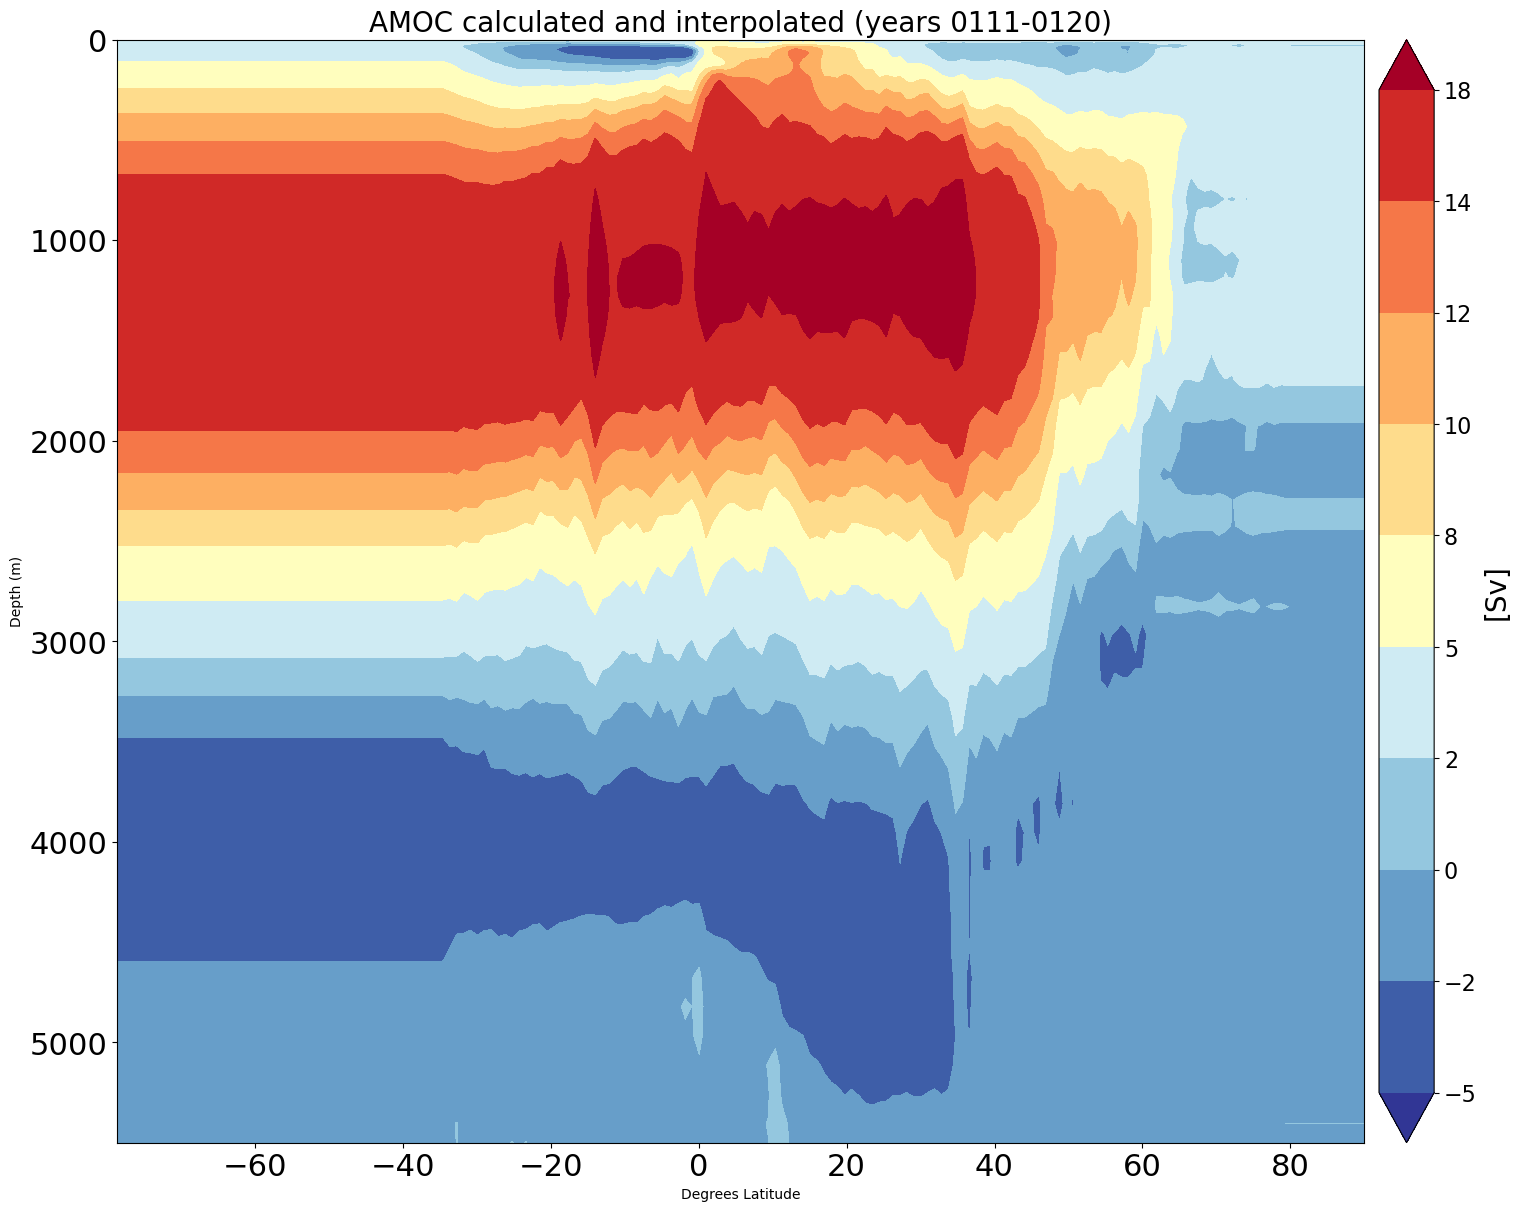

In [114]:
cmap = plt.cm.get_cmap('RdYlBu')
cmap_reversed = cmap.reversed()

fig, ax = plt.subplots(figsize=(16, 12))
cons=ax.contourf(lat_deg, lev, amoc_interp*0.000001,                  
             levels=np.array([-5,-2,0,2,5,8,10,12,14,18]) ,
             #vmin = -2, vmax= 2,
             cmap=cmap_reversed,extend='both')
ax.set_ylim(5500,0)
plt.gca().set_facecolor("grey")  # nan values to grey
cbar = fig.colorbar(cons, orientation='vertical', pad=0.01)
cbar.set_label('[Sv]', size=20)
cbar.ax.tick_params(labelsize=16)
ax.set_ylabel('Depth (m)')
ax.set_xlabel('Degrees Latitude')
ax.tick_params(axis='both', which='major', labelsize=22)
ax.set_title('AMOC calculated and interpolated (years 0111-0120)',fontsize=20)
fig.tight_layout(pad=0.3)
plt.savefig('/pscratch/sd/a/abhi305/Plots/AMOC_calculated_n_interpolated_years_0111_0120', dpi=300)

/tmp/ipykernel_633681/3465113891.py:1: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('RdYlBu')


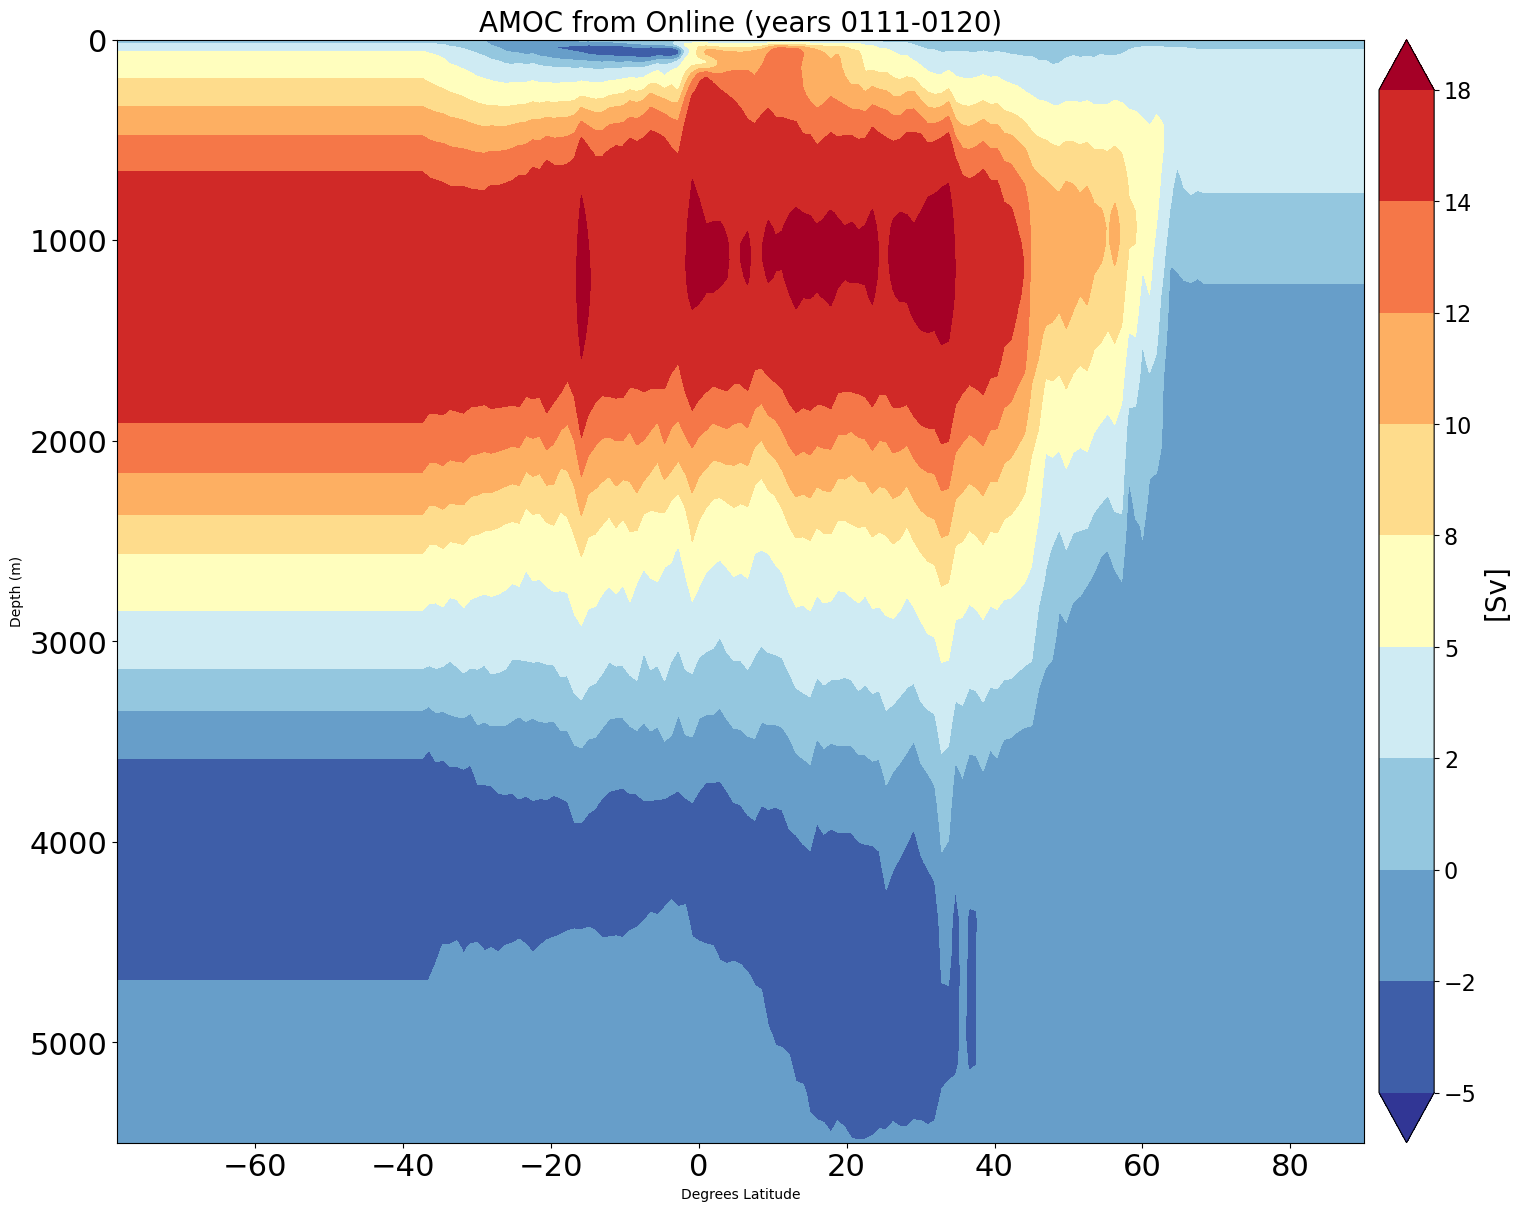

In [112]:
cmap = plt.cm.get_cmap('RdYlBu')
cmap_reversed = cmap.reversed()

fig, ax = plt.subplots(figsize=(16, 12))
cons=ax.contourf(lat_deg, lev, amoc_onl,                  
             levels=np.array([-5,-2,0,2,5,8,10,12,14,18]) ,
             #vmin = -2, vmax= 2,
             cmap=cmap_reversed,extend='both')
ax.set_ylim(5500,0)
plt.gca().set_facecolor("grey")  # nan values to grey
cbar = fig.colorbar(cons, orientation='vertical', pad=0.01)
cbar.set_label('[Sv]', size=20)
cbar.ax.tick_params(labelsize=16)
ax.set_ylabel('Depth (m)')
ax.set_xlabel('Degrees Latitude')
ax.tick_params(axis='both', which='major', labelsize=22)
ax.set_title('AMOC from Online (years 0111-0120)',fontsize=20)
fig.tight_layout(pad=0.3)
plt.savefig('/pscratch/sd/a/abhi305/Plots/AMOC_from_Online_years_0111_0120', dpi=300)

# add a small box to the bottom corner representing zpo.max()

## Difference plot

In [ ]:
cmap = plt.cm.get_cmap('RdYlBu')
cmap_reversed = cmap.reversed()

fig, ax = plt.subplots(figsize=(16, 12))
cons=ax.contourf(lat_deg, lev, amoc_onl - amoc_interp*0.000001,                  
             #levels=np.arange(-4,4,0.5) ,
             #vmin = -2, vmax= 2,
             cmap=cmap_reversed,extend='both')
#iso=ax.contour(xp, yp, rh, colors='tab:green', linestyles='--', linewidths=1.5)
#ax.clabel(iso, fmt='%d')
ax.set_ylim(5500,0)
plt.gca().set_facecolor("grey")  # nan values to grey
cbar = fig.colorbar(cons, orientation='vertical', pad=0.01)
cbar.set_label('[Sv]', size=20)
cbar.ax.tick_params(labelsize=16)
ax.set_ylabel('Depth (m)')
ax.set_xlabel('Degrees Latitude')
ax.tick_params(axis='both', which='major', labelsize=22)
ax.set_title('AMOC from Online - AMOC calculated (years 0111-0120)',fontsize=20)
fig.tight_layout(pad=0.3)
plt.savefig('/pscratch/sd/a/abhi305/Plots/difference_Online_vs_calc_years_0111_0120', dpi=300)

# add a small box to the bottom corner representing zpo.max()

In [95]:
np.min(amoc_onl - amoc_interp)

<xarray.DataArray 'timeMonthly_avg_mocStreamvalLatAndDepthRegion' ()>
array(-20655630.07220459)